<a href="https://colab.research.google.com/github/juanninocruz/Estadistica/blob/main/Cuaderno_19_DBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**19.6 Taller Clustering de Clientes con modelo jerárquico**

Vamos a realizar el mismo taller de clusterización de las secciones anteriores usando DBSCAN y a crear los clústeres. Es importante aclarar que en modelos con un número de características
grande es mejor utilizar algún método de reducción de características. Aunque el tema lo vamos a analizar con profundidad en la siguiente unidad es importante aplicarlo desde aquí.

**Cargar y Preprocesar los Datos**


Este bloque de código realiza una serie de pasos fundamentales para cargar, procesar y visualizar un conjunto de datos. A continuación, explico cada paso del código proporcionado.

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Cargar los datos desde la URL
url = "https://raw.githubusercontent.com/adiacla/bigdata/refs/heads/master/Shopping_CustomerData.csv"
data = pd.read_csv(url)
# Visualizar las primeras filas de los datos
data

,ID,Genero,Edad,Ciudad,Ingresos,Credito,gastos,trabajo
0,1001,Male,49,Bengaluru,527547.58850,653,78,1
1,1002,Male,59,Bengaluru,207143.19760,630,63,1
2,1003,Female,54,Delhi,164423.84570,555,69,4
3,1004,Female,42,Bengaluru,56220.36443,699,30,1
4,1005,Female,30,Bengaluru,256194.36190,793,6,1
...,...,...,...,...,...,...,...,...
195,1196,Female,54,Delhi,317466.42070,601,52,4
196,1197,Female,20,Bengaluru,323305.50020,554,58,1
197,1198,Male,44,Chennai,109058.54430,844,36,2
198,1199,Male,28,Delhi,160116.89300,837,24,4


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        200 non-null    int64  
 1   Genero    200 non-null    object 
 2   Edad      200 non-null    int64  
 3   Ciudad    200 non-null    object 
 4   Ingresos  200 non-null    float64
 5   Credito   200 non-null    int64  
 6   gastos    200 non-null    int64  
 7   trabajo   200 non-null    int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 12.6+ KB


In [11]:
data.describe()

,ID,Edad,Ingresos,Credito,gastos,trabajo
count,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000
mean,1100.500000,45.520000,285143.931646,719.975000,50.70500,2.850000
std,57.879185,16.113592,169229.187619,104.578236,28.72269,1.475938
min,1001.000000,18.000000,2577.057456,551.000000,2.00000,1.000000
25%,1050.750000,31.750000,153227.340950,628.250000,27.75000,1.750000
50%,1100.500000,46.500000,263418.505550,715.000000,48.00000,3.000000
75%,1150.250000,59.000000,384857.116200,806.250000,77.00000,4.000000
max,1200.000000,75.000000,695407.091700,897.000000,100.00000,5.000000


**Es importante que los datos no tengan nulos.**

In [12]:
data.isnull().sum()

,0
ID,0
Genero,0
Edad,0
Ciudad,0
Ingresos,0
Credito,0
gastos,0
trabajo,0


**Codificar la variable 'Genero' (Male = 0, Female = 1):**


Este paso transforma la información categórica en una forma numérica para su compatibilidad con algoritmos de clustering y selecciona las características clave que representan a cada
cliente, preparándolas para el análisis posterior.

**Estandarizar las variables**

Este paso estandariza las características seleccionadas para garantizar que estén en la misma escala. Esto es esencial en métodos de clustering como DBSCAN, que dependen de las
distancias entre puntos y pueden verse afectados por diferencias en las magnitudes de las variables.

In [13]:
# Codificar la variable 'Genero' (Male = 0, Female = 1)
data['Genero'] = data['Genero'].map({'Male': 0, 'Female': 1})
# Seleccionar las columnas numéricas para la segmentación (eliminando ID y Ciudad)
data_numeric = data[['Edad', 'Ingresos', 'Credito', 'gastos', 'trabajo', 'Genero']]
# Normalizar los datos numéricos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)
# Visualizar las primeras filas de los datos escalados
data_scaled

array([[ 0.2165087 ,  1.43599311, -0.64203672,  0.95267867, -1.25658588,
        -1.12815215],
       [ 0.83866013, -0.46207437, -0.86251966,  0.42913296, -1.25658588,
        -1.12815215],
       [ 0.52758441, -0.71514273, -1.58148576,  0.63855125,  0.78112095,
         0.88640526],
       ...,
       [-0.09456702, -1.04312537,  1.18893027, -0.51324931, -0.57735027,
        -1.12815215],
       [-1.0900093 , -0.74065701,  1.12182677, -0.93208587,  0.78112095,
        -1.12815215],
       [-0.28121245, -0.02999037,  0.66168846, -0.68776454, -0.57735027,
        -1.12815215]])

**Reducir la dimensionalidad**

Como se mencionó anteriormente, aunque no hemos revisado PCA en los contenidos anteriores y se va a tratar en la siguiente unidad, para este ejercicio vamos a reducir la dimensionalidad
de los datos para facilitar el análisis y mejorar el rendimiento de algoritmos que son sensibles al número de dimensiones. Adelantamos definiendo que PCA identifica las combinaciones lineales de características originales que capturan la mayor parte de la variación en los datos, garantizando una representación más compacta sin perder información relevante.

In [14]:
# Realizar PCA o reducción de dimensiones si es necesario
from sklearn.decomposition import PCA
pca = PCA(n_components=3) # Por ejemplo, reducir a 3 componentes
data_reduced = pca.fit_transform(data_scaled)
data_reduced

array([[-7.46006209e-01, -1.82712957e+00,  1.18608093e+00],
       [-1.76583144e+00, -1.05446233e+00, -2.37874805e-01],
       [ 3.91257767e-01, -1.05450630e+00, -1.76337015e+00],
       [-7.33404605e-01,  5.58531484e-01, -5.01769489e-01],
       [-2.16854205e-01,  1.32241113e+00,  9.13347085e-01],
       [ 1.13036313e+00, -1.96291820e+00,  4.16589187e-01],
       [-2.84361822e-01,  2.03500940e+00,  7.90328771e-01],
       [ 2.63670523e+00,  5.78075674e-01,  4.05908545e-01],
       [-1.97037068e+00,  6.70106685e-01, -4.46309707e-01],
       [ 7.93032142e-01, -1.05733070e+00, -9.78216094e-01],
       [-2.33269060e+00, -7.45913539e-03, -1.43577935e-01],
       [-1.06491689e+00, -1.45324461e+00, -2.66961415e-01],
       [ 9.61796057e-01, -5.31666826e-01, -2.07045757e-02],
       [ 1.36206043e+00,  1.46945131e-02, -3.47154887e-01],
       [-1.52950545e+00,  4.98017443e-02,  4.06780473e-01],
       [-5.73967187e-01,  1.08350058e+00,  1.10085233e+00],
       [-3.76014039e-01,  1.36048632e+00

**Configurar los hiperparámetros**


En este paso, se están configurando los hiperparámetros para el algoritmo DBSCAN:

**epsilon (eps):** define el radio de proximidad para los puntos vecinos. En este caso, está configurado como 0.5, lo que significa que sólo los puntos dentro de este radio se considerarán vecinos.

**min_samples: **especifica el número mínimo de puntos en la vecindad para que un punto sea considerado como un "punto central". Está configurado en 10.

Luego, se aplica DBSCAN a los datos estandarizados con dbscan.fit_predict(data_scaled),
que realiza el clustering y asigna etiquetas a cada punto de datos.


In [27]:
# --- Hiperparámetros ---
epsilon = 0.58 # Ajustar según los datos
min_samples = 2 # Ajustar según los datos
# Aplicar DBSCAN
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples, metric='euclidean')
clusters = dbscan.fit_predict(data_reduced)
clusters

array([ 0,  1,  2,  2,  3,  4,  5,  6,  2,  2,  7,  2,  2, -1,  8,  3,  9,
        2,  2, -1,  2,  8,  2,  2,  2, -1,  2,  2, 10,  2,  7, -1,  2,  2,
        2,  2, 11,  6,  2,  2, 12,  2,  8,  2, -1,  3, -1, 10,  2,  2,  2,
        8,  2,  9, -1,  2,  2,  8, 12,  8,  2, -1, -1,  2,  8,  8,  2, 10,
        0, -1,  5,  2, 11,  2,  2,  2,  2, -1,  2,  3,  3, 13,  2,  2,  2,
        2, -1, -1,  2,  2, 10,  2,  2, -1,  8, 13, 12, -1,  2,  8,  2,  2,
       13,  2,  8,  2,  2, -1,  2,  2, -1,  2,  2,  2, -1,  2,  2, -1,  4,
       14,  8, 15, -1,  2,  2,  2,  7,  8,  0,  0,  2, -1,  2, -1,  2,  6,
        2, -1,  3,  2,  2,  2, 14, 14,  2,  2, 13, 10, -1,  2,  2,  2,  2,
       -1,  2,  4,  5,  2,  8, -1,  2, 15,  2,  2,  8,  2, -1,  2,  2,  2,
        1,  2,  8,  2, -1, -1,  2, -1,  2,  2,  2,  2,  2,  2,  5,  2,  2,
        8,  2,  2, 11, 10, -1,  2, -1,  2,  2,  2,  9,  2])

**El número -1:** en DBSCAN, el valor -1 identifica puntos clasificados como ruido. Esto ocurre
cuando un punto no pertenece a ningún clúster por las siguientes razones.
* Vecinos insuficientes: el número de puntos dentro del radio epsilon no alcanza el umbral min_samples.
* Densidad aislada: los puntos están demasiado dispersos y no forman parte de ninguna región densa.

**Cantidad de clústeres:** en el resultado proporcionado, los clústeres únicos (excluyendo -1)
son:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Esto indica que se detectaron 16 clústeres válidos.

**Asignar los clientes a los clústeres**

In [18]:
#Asignar el clúster a cada cliente
data['Cluster'] = clusters
data

,ID,Genero,Edad,Ciudad,Ingresos,Credito,gastos,trabajo,Cluster
0,1001,0,49,Bengaluru,527547.58850,653,78,1,0
1,1002,0,59,Bengaluru,207143.19760,630,63,1,1
2,1003,1,54,Delhi,164423.84570,555,69,4,2
3,1004,1,42,Bengaluru,56220.36443,699,30,1,2
4,1005,1,30,Bengaluru,256194.36190,793,6,1,3
...,...,...,...,...,...,...,...,...,...
195,1196,1,54,Delhi,317466.42070,601,52,4,2
196,1197,1,20,Bengaluru,323305.50020,554,58,1,2
197,1198,0,44,Chennai,109058.54430,844,36,2,2
198,1199,0,28,Delhi,160116.89300,837,24,4,9


In [20]:
# Calcular el Silhouette Score (si hay más de 1 clúster)
if len(set(clusters)) > 1:
  silhouette_avg = silhouette_score(data_reduced, clusters)
  print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: -0.09806865693553117


Este código calcula el Silhouette Score, que mide qué tan bien definidos están los clústeres creados por el algoritmo DBSCAN. Si hay más de un clúster (excluyendo ruido), el Silhouette
Score varía entre -1 y 1:

* Valores cercanos a 1 indican clústeres compactos y bien separados.
* Valores cercanos a 0 indican clústeres solapados.
* Valores negativos sugieren asignaciones incorrectas.

En este caso se evidencia que deberíamos hacer algunos procesos adicionales de ingeniería
de características. Si todos los puntos están en un único clúster o ruido, el score no se calcula
para evitar resultados irrelevantes.

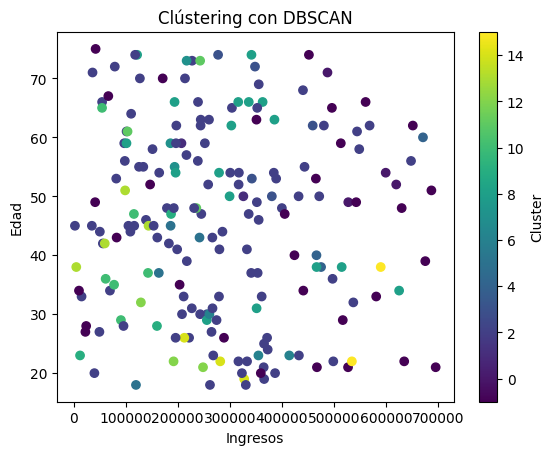

In [23]:
# Visualización
plt.scatter(data['Ingresos'], data['Edad'], c=data['Cluster'], cmap='viridis')
plt.title("Clústering con DBSCAN")
plt.xlabel("Ingresos")
plt.ylabel("Edad")
plt.colorbar(label="Cluster")
plt.show()

**Número óptimo de epsilon**

El siguiente código se utiliza para determinar un valor adecuado para el parámetro epsilon (eps) en el algoritmo DBSCAN. El objetivo principal de este proceso es identificar un punto de
corte óptimo que permita al modelo formar clústeres significativos, evitando tanto el subagrupamiento como el sobreagrupamiento.
* Cálculo de las distancias a los vecinos más cercanos : usamos NearestNeighbors para calcular las distancias a los 10 vecinos más cercanos para cada punto en los datos.Estas distancias ayudan a entender cómo están distribuidos los puntos en el espacio.
* Ordenar las distancias: al ordenar las distancias de los décimos vecinos más cercanos,
se facilita la identificación de un punto donde estas distancias experimentan un cambio abrupto, conocido como el "codo" inverso.
* Graficar el codo: la gráfica de las distancias ayuda a visualizar la distribución de los puntos. El "codo" (inverso) en la gráfica indica un cambio significativo en las distancias,
lo que sugiere un valor adecuado para eps.
Un valor correcto de eps permite al algoritmo capturar correctamente la densidad de los puntos en los clústeres y diferenciar clústeres de ruido.

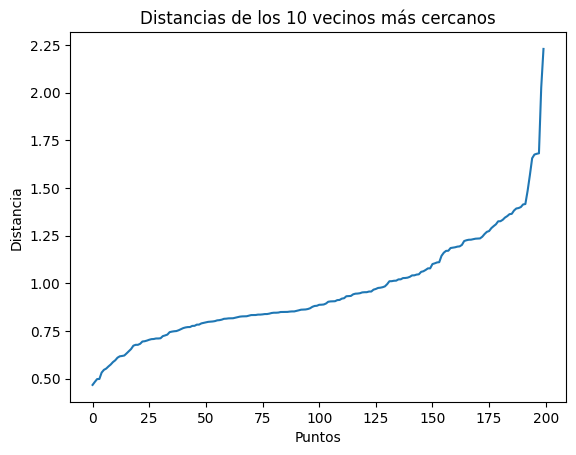

In [24]:
from sklearn.neighbors import NearestNeighbors

# Calcular la distancia entre puntos vecinos más cercanos
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(data_reduced)
distances, indices = neighbors_fit.kneighbors(data_reduced)
# Ordenar distancias
distances = np.sort(distances[:,9], axis=0)
# Graficar el "codo" para identificar un buen epsilon
plt.plot(distances)
plt.xlabel('Puntos')
plt.ylabel('Distancia')
plt.title('Distancias de los 10 vecinos más cercanos')
plt.show()

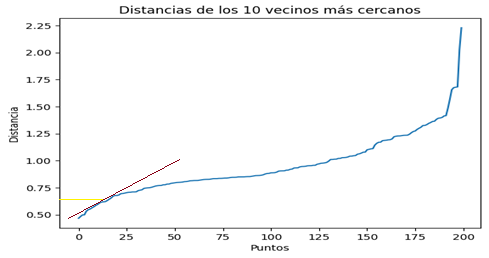

**Salida final**

**Número de clústeres encontrados:** indica cuántos grupos se identificaron en los datos.

**Número de outliers encontrados:** muestra cuántos puntos no pertenecen a ningún clúster (ruido).

In [25]:
# Número de clústeres y observaciones "outliers"
# ==============================================================================
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise = list(clusters).count(-1)
print(f'Número de clústeres encontrados: {n_clusters}')
print(f'Número de outliers encontrados: {n_noise}')

Número de clústeres encontrados: 16
Número de outliers encontrados: 32
